In [35]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

Load data

In [36]:
train = fetch_20newsgroups(subset='train', shuffle=True)
print(type(train))
print(dir(train))
print(len(train.data))
print("Target names:", train.target_names)
print("------------------------------------")
for text, label in zip(train.data[:3], train.target[:3]):
    print("Text:", text[:100])
    print("Label:", train.target_names[label])
    print("------------------------------------")

<class 'sklearn.utils._bunch.Bunch'>
['DESCR', 'data', 'filenames', 'target', 'target_names']
11314
Target names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
------------------------------------
Text: From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.
Label: rec.autos
------------------------------------
Text: From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final ca
Label: comp.sys.mac.hardware
------------------------------------
Text: From: twillis@ec.ecn.purdue.edu (Thomas E Willis)
Subject: PB questions...
Organization: Purdue Univ
Label: comp.sy

Stemming

In [37]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

Pipelines

In [38]:
pipelines = {
    "DTC": Pipeline(
        [
            ("vect", CountVectorizer()),
            ("tfidf", TfidfTransformer()),
            ("dtc", DecisionTreeClassifier()),
        ]
    ),
    "DTC stop words": Pipeline(
        [
            ("vect", CountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("dtc", DecisionTreeClassifier()),
        ]
    ),
    "DTC stemming": Pipeline(
        [
            ("vect", StemmedCountVectorizer()),
            ("tfidf", TfidfTransformer()),
            ("dtc", DecisionTreeClassifier()),
        ]
    ),
    "DTC stop words + stemming": Pipeline(
        [
            ("vect", StemmedCountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("dtc", DecisionTreeClassifier()),
        ]
    ),
    "RFC": Pipeline(
        [
            ("vect", CountVectorizer()),
            ("tfidf", TfidfTransformer()),
            ("dtc", RandomForestClassifier()),
        ]
    ),
    "RFC stop words": Pipeline(
        [
            ("vect", CountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("dtc", RandomForestClassifier()),
        ]
    ),
    "RFC stemming": Pipeline(
        [
            ("vect", StemmedCountVectorizer()),
            ("tfidf", TfidfTransformer()),
            ("dtc", RandomForestClassifier()),
        ]
    ),
    "RFC stop words + stemming": Pipeline(
        [
            ("vect", StemmedCountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("dtc", RandomForestClassifier()),
        ]
    ),
}

In [39]:
for key, pipeline in pipelines.items():
    pipeline = pipeline.fit(train.data, train.target)
    test = fetch_20newsgroups(subset='test', shuffle=True)
    predicted = pipeline.predict(test.data)
    print(f"{key}: {np.mean(predicted == test.target)}")

DTC: 0.5464684014869888
DTC stop words: 0.5720924057355284
DTC stemming: 0.5539033457249071
DTC stop words + stemming: 0.5728890069038768
RFC: 0.7591609134360063
RFC stop words: 0.7851832182687202
RFC stemming: 0.7648698884758365
RFC stop words + stemming: 0.7849176845459374


It seems that stemming and removing stopwords helps

In [40]:
models = {
    "DTC": Pipeline(
        [
            ("vect", StemmedCountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("dtc", DecisionTreeClassifier()),
        ]
    ),
    "RFC": Pipeline(
        [
            ("vect", StemmedCountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("dtc", RandomForestClassifier()),
        ]
    ),
    "Naive Bayes": Pipeline(
        [
            ("vect", StemmedCountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("nb", MultinomialNB()),
        ]
    ),
    "SVM": Pipeline(
        [
            ("vect", StemmedCountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("svm", SVC(kernel="linear")),
        ]
    ),
}

Cross validation

DTC:
	mean: 0.6512,	std: 0.0122
RFC:
	mean: 0.8543,	std: 0.0075
Naive Bayes:
	mean: 0.8751,	std: 0.0065
SVM:
	mean: 0.9166,	std: 0.0032


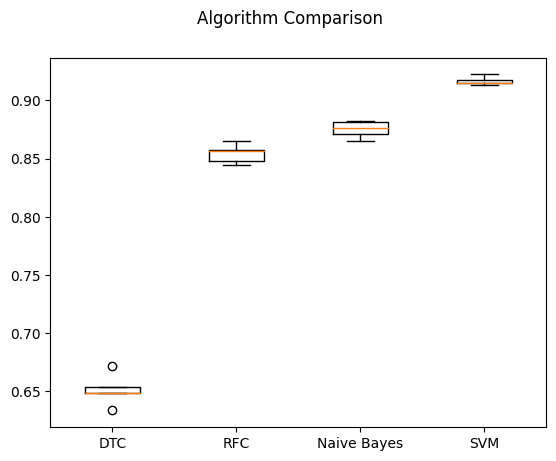

In [41]:
results = []
names = []
scoring = "accuracy"

# Cross validation
for name, model in models.items():
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_val_score(model, train.data, train.target, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"\033[94m{name}\033[0m:\n\tmean: {cv_results.mean():.4f},\tstd: {cv_results.std():.4f}")

# Plotting
fig = plt.figure()
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()